# Vehicle Detection and Tracking

Importing necessary libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from numpy import random
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip

%matplotlib inline

## Color and HOG features extraction

In [2]:
# Computes binned color features  
def bin_spatial(img, size=(32, 32)):
    # Using cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Returnig the feature vector
    return features


# Computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Computing the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenating the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returning the individual histograms, bin_centers and feature vector
    return hist_features


# Gets HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Calling with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise calling with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Methods to extract the combined HOG and color features

In [7]:
# Converts an image to the given color space
# Color space can be RGB, HSV, LUV, HLS, YUV, YCrCb
def convert_color(image, cspace='YCrCb'):
    # Applying color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(image)


# Extracts the combined HOG and color features
def extract_features(imgs, cspace='RGB', 
                     spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Creating a list to append feature vectors to
    features = []
    # Iterating through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # Applying color conversion
        feature_image = convert_color(image, cspace=cspace)

        # Applying bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Applying color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Calling get_hog_features() with vis=False, feature_vec=True
        # to get the HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Appending the new feature vector to the features list
        features.append(np.ravel(np.hstack((spatial_features, hist_features, hog_features))))
    # Returning the list of feature vectors
    return features

## Training a Classifier

### Getting image samples for training/test set

In [247]:
NO_SAMPLES_PER_CLASS = 5000

cars = []
notcars = []

cars_images = random.choice(glob.glob('training_images/vehicles/*/*.png'), NO_SAMPLES_PER_CLASS)
for image in cars_images:
    cars.append(image)

notcars_images = random.choice(glob.glob('training_images/non-vehicles/*/*.png'), NO_SAMPLES_PER_CLASS)
for image in notcars_images:
    notcars.append(image)

print('Number of car images', len(cars))
print('Number of not-car images', len(notcars))

Number of car images 5000
Number of not-car images 5000


Testing sample data

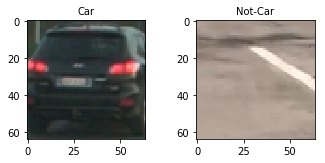

In [248]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3))
f.tight_layout()
ax1.imshow(mpimg.imread(random.choice(cars)))
ax1.set_title('Car', fontsize=10)
ax2.imshow(mpimg.imread(random.choice(notcars)))
ax2.set_title('Not-Car', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/TrainingDataSample.png")

### Extracting features from training/test set and preparing for training

In [249]:
# Parameters for feature extraction
spatial        = 32
histbin        = 32
colorspace     = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9
pix_per_cell   = 8
cell_per_block = 2
hog_channel    = 'ALL' # Can be 0, 1, 2, or "ALL"


# Extracting features for car images
car_features = extract_features(cars, cspace=colorspace,
                                spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256),
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
# Extracting features for not-car images
notcar_features = extract_features(notcars, cspace=colorspace,
                                   spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256),
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   hog_channel=hog_channel)


# Creating an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fitting a per-column scaler
X_scaler = StandardScaler().fit(X)
# Applying the scaler to X
scaled_X = X_scaler.transform(X)

# Defining the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Splitting up the data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


### Defining and Training Classifier

In [250]:
# Classifier
clf = LinearSVC()
#clf = SVC()
#clf = DecisionTreeClassifier()

# Checking the training time for the classifier
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Training Accuracy of Classifier = ', round(clf.score(X_train, y_train), 4))
print(round(t2-t, 2), 'Seconds to train classifer.\n')

# Checking the score of the classifier
print('Test Accuracy of Classifier = ', round(clf.score(X_test, y_test), 4), '\n')

# Checking the prediction time for a single sample
t=time.time()
n_predict = 10
print('Classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict, 'labels with classifier')

Training Accuracy of Classifier =  1.0
24.54 Seconds to train classifer.

Test Accuracy of Classifier =  0.9955 

Classifier predicts:  [ 0.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00261 Seconds to predict 10 labels with classifier


Saving classifier's data to a pickle file

In [251]:
classifier_data = {
    "clf" : clf,
    "scaler": X_scaler,
    "orient": orient,
    "pix_per_cell": pix_per_cell,
    "cell_per_block": cell_per_block,
    "spatial_size": (spatial, spatial),
    "hist_bins": histbin
}

with open('clf_pickle.p', 'wb') as handle:
    pickle.dump(classifier_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Car identification

Methods to identify regions of an image containing cars using the windows sliding approach. Also methods to discard false positives using heatmaps are implemented.

In [252]:
# Returns a collection of boxes corresponding to the predictions of cells that contains cars,
# using the Window Sliding approach.
# It extracts HOG features of the whole image then it uses HOG sub-sampling and
# extracting color features from sub-images
def find_cars(img, xstart, xstop, ystart, ystop, scale,
              clf, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):

    img = img.astype(np.float32)/255
    # Sub-images to perform the search on
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    # Transforming image to YCrCb color space
    ctrans_tosearch = convert_color(img_tosearch, cspace='YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Color channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Defining blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Computing individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extracting HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extracting the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Getting color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scaling features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)

            # If the image patch is predicated to contain a car, the box is added to the collection to return
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bboxes.append(((xbox_left + xstart, ytop_draw + ystart),
                               (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))

    return bboxes


# Performs the process of cars identification per different scales for the image patches
def find_cars_multi_scale(img, xstart, xstop, ystart, ystop, scales,
                          clf, X_scaler,
                          orient, pix_per_cell, cell_per_block,
                          spatial_size, hist_bins):
    bboxes = []
    for scale in scales:
        bboxes += find_cars(img, xstart, xstop, ystart, ystop, scale,
                            clf, X_scaler,
                            orient, pix_per_cell, cell_per_block,
                            spatial_size, hist_bins)
    return bboxes


# Draws a collection of boxes in an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Making a copy of the image
    draw_img = np.copy(img)
    # Drawing each bounding box on the image's copy using cv2.rectangle()
    for bbox in bboxes:
        # Drawing a rectangle given the bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Returning the image's copy with boxes drawn
    return draw_img


# Adds a given heat amount in the heatmap inside the given boxes
def add_heat(heatmap, bboxes, heat_amt=1):
    # Iterating through the list of bboxes
    for box in bboxes:
        # Adding heat_amt for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat_amt
    # Returning the updated heatmap
    return heatmap


# Dilutes the existing heat in a heatmap given a spacific ratio
def dilute_heat(heatmap, dilution_ratio=0.5):
    # Multiplying all the pixels by the given ratio
    heatmap *= dilution_ratio
    return heatmap


# Zeroes the heatmap's pixels under a given threshold
def apply_threshold(heatmap, threshold):
    # Zeroing out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Returning thresholded map
    return heatmap


# Sets the heat in a heatmap, considering the previous status of the heatmat
# the amount of heat to add per box, a given threshold 
# and a dilution ratio applied to the previous status
def set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=2, dilution_ratio=0.5):
    dilute_heat(heatmap, dilution_ratio=0.5)
    add_heat(heatmap, bboxes, heat_amt)
    apply_threshold(heatmap, heat_threshold)
    return heatmap


# Draws the boxes corresponding to the regions identified in the labels collections
# which come from a heatmap
def draw_labeled_bboxes(img, labels):
    # Iterating through all detected cars
    for car_number in range(1, labels[1]+1):
        # Finding pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identifying x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Defining a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Drawing the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Returning the image
    return img

Loading the classifier data from a pickle file

In [253]:
classifier_data = pickle.load(open("clf_pickle.p", "rb" ))
clf = classifier_data["clf"]
X_scaler = classifier_data["scaler"]
orient = classifier_data["orient"]
pix_per_cell = classifier_data["pix_per_cell"]
cell_per_block = classifier_data["cell_per_block"]
spatial_size = classifier_data["spatial_size"]
hist_bins = classifier_data["hist_bins"]

# Checking the score of the classifier
print('Test Accuracy of Classifier = ', round(clf.score(X_test, y_test), 4), '\n')

Test Accuracy of Classifier =  0.9955 



Testing the mechanims to identify cars

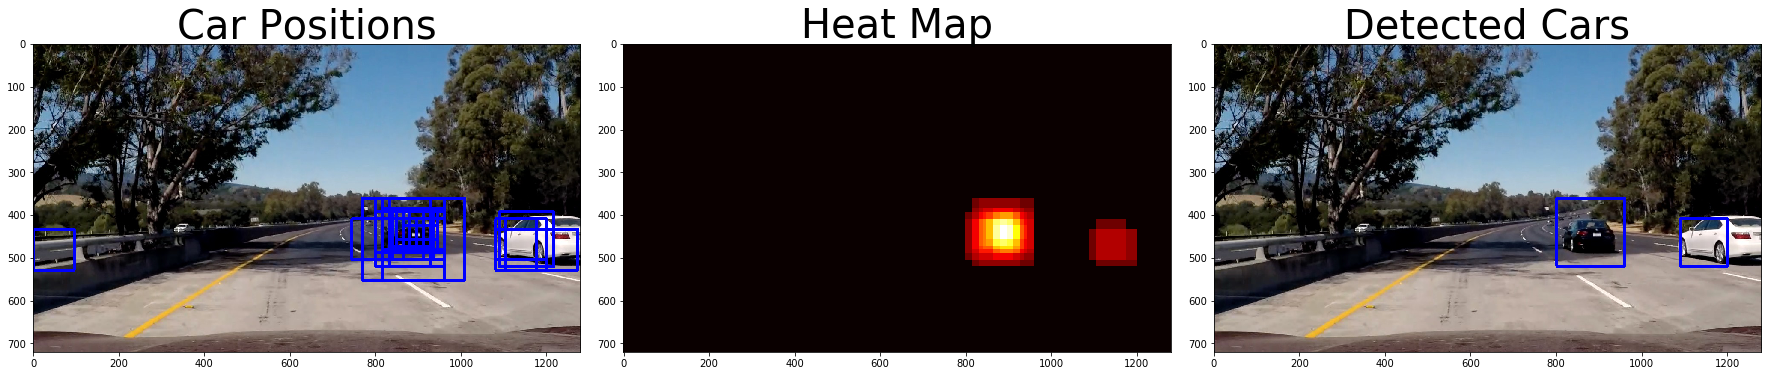

In [257]:
#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
#img = mpimg.imread('test_images/test4.jpg')
img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test6.jpg')

xstart = 0 #0
xstop = 1280 #1280
ystart = 360 #400
ystop = 720 #656
scale = 1.0 #2.0
heat_threshold = 3

#bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [3.0],
bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [1.0, 1.5, 2.0, 3.0],
#bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [0.5, 1.0, 2.0, 4.0],
#bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [1.0, 1.5, 2.0, 3.0, 4.0],
                               clf, X_scaler,
                               orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins)
out_img = draw_boxes(img, bboxes)

heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=4, dilution_ratio=0.5)
heatmap_img = np.clip(heatmap, 0, 255)
labels = label(heatmap_img)
draw_img = draw_labeled_bboxes(np.copy(img), labels)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Car Positions', fontsize=40)
ax2.imshow(heatmap_img, cmap='hot')
ax2.set_title('Heat Map', fontsize=40)
ax3.imshow(draw_img)
ax3.set_title('Detected Cars', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)

Pipeline to process a sequence of images

In [260]:
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
frames_interval = 10
frame_count = 0
labels = None

def process_image(img):
    global heatmap
    global frames_interval
    global frame_count
    global labels

    if frame_count % frames_interval == 0:
        bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [1.0, 1.5, 2.0, 3.0],
                                       clf, X_scaler,
                                       orient, pix_per_cell, cell_per_block,
                                       spatial_size, hist_bins)
        set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=6, dilution_ratio=0.5)
        #set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=3, dilution_ratio=0.0)
        heatmap_img = np.clip(heatmap, 0, 255)
        labels = label(heatmap_img)

    frame_count += 1
    #return draw_labeled_bboxes(np.copy(img), labels)
    return draw_labeled_bboxes(img, labels)

## Generating Video

In [261]:
video_output = 'test09.mp4'
#clip1 = VideoFileClip('test_video.mp4')
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('project_video.mp4').subclip(35,42)
#clip1 = VideoFileClip('project_video.mp4').subclip(40,50)
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test08.mp4
[MoviePy] Writing video test08.mp4


100%|█████████▉| 1260/1261 [07:42<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test08.mp4 

CPU times: user 7min 43s, sys: 5.18 s, total: 7min 48s
Wall time: 7min 43s


## Recycled code

In [ ]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [ ]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [ ]:
# COLOR FEATURES

# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_color_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                                      hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_color_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                                         hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
# HOG FEATURES

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)